<a href="https://colab.research.google.com/github/clyde2020/ML_Portfolio/blob/main/Barrier_Reef.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import cv2
import matplotlib.pyplot as plt
!pip install keras_preprocessing
import keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
df = pd.read_csv('/content/gdrive/MyDrive/Barrier Reef/train.csv')
train_comp = '/content/gdrive/MyDrive/Barrier Reef/small_train'
file_list = os.listdir(train_comp)

num_files = len(file_list)

num_classes = 10
batch_size = 16
columns = ['loc_1',
           'bb_x1',
           'bb_y1',
           'bb_w1',
           'bb_h1',
           'loc_2',
           'bb_x2',
           'bb_y2',
           'bb_w2',
           'bb_h2']

In [37]:
def append_ext(file):
  return file + '.jpg'

In [38]:
df['video_frame'] = df['video_frame'].astype('str')
df['video_frame'] = df['video_frame'].apply(append_ext)

In [39]:
small_df = df[:num_files]
df_to_process = small_df['annotations']
blank_labels = np.zeros(shape=(len(df_to_process), num_classes))

In [40]:
def process_data(data, y):
  first_list = []
  final_list = []

  for val in data:
    if len(val) < 10:
      first_list.append('0')
    elif len(val) > 10 and len(val) < 70:
      item = val[2:-2]
      first_list.append(item)
    elif len(val) > 70:
      item = val[2:-2]
      item = item.replace("}, {", ", ")
      # new_item = re.split(pattern = r'[,:]', string = item)
      first_list.append(item)

  i = 0

  for item in first_list:
    if len(item) < 10:
      final_list.append('0')
    elif len(item) > 10:
      new_item = re.split(pattern = r'[,:]', string = first_list[i])
      final_list.append(new_item)
    i += 1

  i = 0
  for val in first_list:
    if len(val) > 10 and len(val) < 70:
      y[i, 0] = 1
      y[i, 5] = 0
    elif len(val) > 70:
      y[i, 0] = 1
      y[i, 5] = 1
    
    i += 1

  i = 0
  for val in final_list:
    j = 1
    if len(val) > 2:
      for num in range(1, len(val), 2):
        if j == 5:
          j = 6
        if j < 10:
          y[i, j] = final_list[i][num]
        j += 1

    i += 1

  col_max = np.amax(y, axis=0)
  y = y / col_max

  return y

In [41]:
labels = process_data(df_to_process, blank_labels)

In [42]:
print(labels[10])
print(labels[20])
print(labels[50])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.         0.4621149  0.30880231 0.35460993 0.25396825 0.
 0.         0.         0.         0.        ]
[1.         0.44879267 0.2958153  0.74468085 0.77777778 1.
 0.89615932 0.53262519 0.67375887 0.44444444]


In [43]:
df_labels = pd.DataFrame(labels, columns=columns)
train_files = pd.DataFrame({'file_name': file_list})
df_labels['file_name'] = train_files['file_name']

In [44]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   #rotation_range=20,
                                   validation_split=0.1)  

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_labels,
    directory=train_comp,
    x_col='file_name',
    y_col=columns,
    target_size=(72, 128),
    batch_size=batch_size,
    class_mode='raw',
    subset='training',
    shuffle=True,
    seed=51)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df_labels,
    directory=train_comp,
    x_col='file_name',
    y_col=columns,
    target_size=(72, 128),
    batch_size=batch_size,
    class_mode='raw',
    subset='validation',
    shuffle=True,
    seed=51) 

Found 1210 validated image filenames.
Found 134 validated image filenames.


In [45]:
base_model = tf.keras.applications.xception.Xception(weights='imagenet',
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
starfish1_output = tf.keras.layers.Dense(1, activation='sigmoid')(avg)
loc1_output = tf.keras.layers.Dense(4, activation='softmax')(avg)
starfish2_output = tf.keras.layers.Dense(1, activation='sigmoid')(avg)
loc2_output = tf.keras.layers.Dense(4, activation='softmax')(avg)
x = tf.keras.layers.Concatenate()([starfish1_output, loc1_output, starfish2_output, loc2_output])
model = tf.keras.models.Model(inputs=base_model.input,
                              outputs=x
                              # outputs=[starfish1_output,
                              #          loc1_output,
                              #          starfish2_output,
                              #          loc2_output]
                              )

for layer in base_model.layers:
  layer.trainable = False

model.compile(loss=['binary_crossentropy', 'mse', 'binary_crossentropy', 'mse'],
              loss_weights=[0.4, 0.15, 0.35, 0.1],
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,
                                                momentum=0.9,
                                                decay=0.001),
              metrics=['accuracy'])
            
              

In [ ]:
model.summary()

In [46]:
model.fit(train_generator,
          batch_size=batch_size,
          validation_data=valid_generator,
          epochs=5,
          verbose=1,
          shuffle=True,)

Epoch 1/5
76/76 [==============================] - 74s 918ms/step - loss: 0.1615 - accuracy: 0.8661 - val_loss: 0.2396 - val_accuracy: 0.9851
Epoch 2/5
76/76 [==============================] - 58s 758ms/step - loss: 0.1539 - accuracy: 0.7455 - val_loss: 0.2401 - val_accuracy: 0.9701
Epoch 3/5
76/76 [==============================] - 68s 896ms/step - loss: 0.1516 - accuracy: 0.7264 - val_loss: 0.2408 - val_accuracy: 0.9552
Epoch 4/5
76/76 [==============================] - 68s 902ms/step - loss: 0.1501 - accuracy: 0.6851 - val_loss: 0.2415 - val_accuracy: 0.9552
Epoch 5/5
76/76 [==============================] - 68s 897ms/step - loss: 0.1490 - accuracy: 0.6950 - val_loss: 0.2418 - val_accuracy: 0.9552


In [ ]:
image = cv2.imread('/content/gdrive/MyDrive/Barrier Reef/small_train/51.jpg')

In [ ]:
image.shape

(720, 1280, 3)

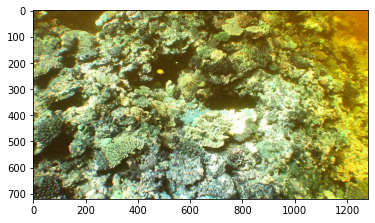

In [ ]:
plt.imshow(image)

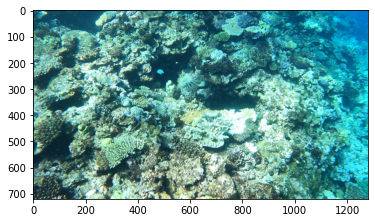

In [ ]:
new_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(new_image)

In [ ]:
new_image